In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import itertools
import math
import pickle
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


from utils.config import *
from utils.ortool import *
from utils.Misc import *
from problems import *
from nets import *
from agents import *
from utils import *
from agents import AgentPPO, Actor_Critic


### Plot vehicle routes

In [2]:

def plot_customers(ax, customers, detailed = True):
    r"""
    :param ax:        Axes object to plot to
    :param customers: :math:`L_c \times D_c` tensor containing customers' features
    :param detailed:  Toggle printing features of each customer next to its node
        Default = False
    :type ax:         matplotlib.pyplot.Axes
    :type customers:  torch.Tensor(dtype = torch.float)
    :type detailed:   bool
    """

    ax.axis('equal')
    ax.set_axis_off()
    if detailed:
        ax.set_title("{} customers (Blue:Static, Red:Dynamic)".format(customers.size(0)-1))

    maxdem = customers[1:,3].max().item()
    mindem = customers[1:,3].min().item()
    s = [120+40*(dem-mindem)/(maxdem-mindem+0.2) for dem in customers[1:,3].tolist()]
    cmap = matplotlib.cm.coolwarm

    if customers.size(1) > 3: # Service time
        c = customers[1:,3].tolist()
        cnorm = matplotlib.colors.Normalize(-0.5, 0.5) # service time mean=10, std=2.5 (min)
    else:
        c = [1.0 for _ in customers[1:]]
        cnorm = matplotlib.colors.Normalize(-1, 1)
    
    ax.scatter(*zip(*customers[0:1,:2].tolist()), 200, 'g', 'd')
    ax.scatter(*zip(*customers[1:,:2].tolist()), s, c, 'o', cmap, cnorm)
            
    for j, cust in enumerate( customers.tolist() ):
        ax.text(cust[0],cust[1],str(j), fontsize = 10,
                horizontalalignment = 'center', verticalalignment = 'center')
    return ax

def discrete_cmap(N, base_cmap='ocean'):
    base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data_to_plot, routes_without_depot, markersize = 5):

    fig, ax1 = plt.subplots(1, 1, figsize = (16,10))
    
    depot = data_to_plot[0,:2].cpu().numpy()
    locs = data_to_plot[1:,:2].cpu().numpy()

    x_dep, y_dep = depot
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')
    cmap = discrete_cmap(len(routes_without_depot) + 2)

    qvs = []
    total_dist = 0

    for veh_number, r in enumerate(routes_without_depot):
        r = np.array(r)
        color = cmap(len(routes_without_depot) - veh_number)
        coords = locs[r-1, :]
        xs, ys = coords.transpose()

        ax1 = plot_customers(ax1, data_to_plot)

        dist = 0
        x_prev, y_prev = x_dep, y_dep

        for (x, y) in coords:
                dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
                x_prev, y_prev = x, y

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist

        xs = np.append(xs,x_dep)
        xs = np.insert(xs,0,x_dep)
        ys = np.append(ys,y_dep)
        ys = np.insert(ys,0,y_dep)


        qv = ax1.quiver(
                        xs[:-1],
                        ys[:-1],
                        xs[1:] - xs[:-1],
                        ys[1:] - ys[:-1],
                        scale_units='xy',
                        angles='xy',
                        scale=1,
                        width = 0.004,
                        color=color,
                        label='Route{}, #Customers {},Distance {:.2f}'.format(
                        veh_number, 
                        len(r), 
                        dist))

        qvs.append(qv)

        ax1.set_title('Blue:Static, Red:Dyanamic,{} routes, total distance {:.2f}'.format(len(routes), total_dist))
        ax1.legend(handles=qvs)

In [21]:
args = ParseArguments()
Lambda = 0.2
dod = 0.75
horizon = 600
vehicle_count = 2

data = torch.load("./data/validation/{}_{}_{}_{}/val.pth".format(Lambda, dod, vehicle_count, horizon ))
data_t = data
data_t.normalize()
print(data_t.vehicle_speed)

2.8452256774714453


In [17]:
torch.pairwise_distance(data_t[:,0,:2], data_t[:,1,:2])

tensor([20.1910, 43.0974, 15.5163, 33.1751, 18.5368])

In [19]:
torch.pairwise_distance(data_t[:,0,:2], data_t[:,1,:2])

tensor([0.0957, 0.2044, 0.0736, 0.1573, 0.0879])

In [29]:
env = DVRPSR_Environment(data_t)
env.reset()
env.step(torch.tensor([[1],[1],[1],[1],[1]]))

torch.Size([5, 161])


tensor([[0.0957],
        [0.2044],
        [0.0736],
        [0.1573],
        [0.0879]])

<Axes: title={'center': '160 customers (Blue:Static, Red:Dynamic)'}>

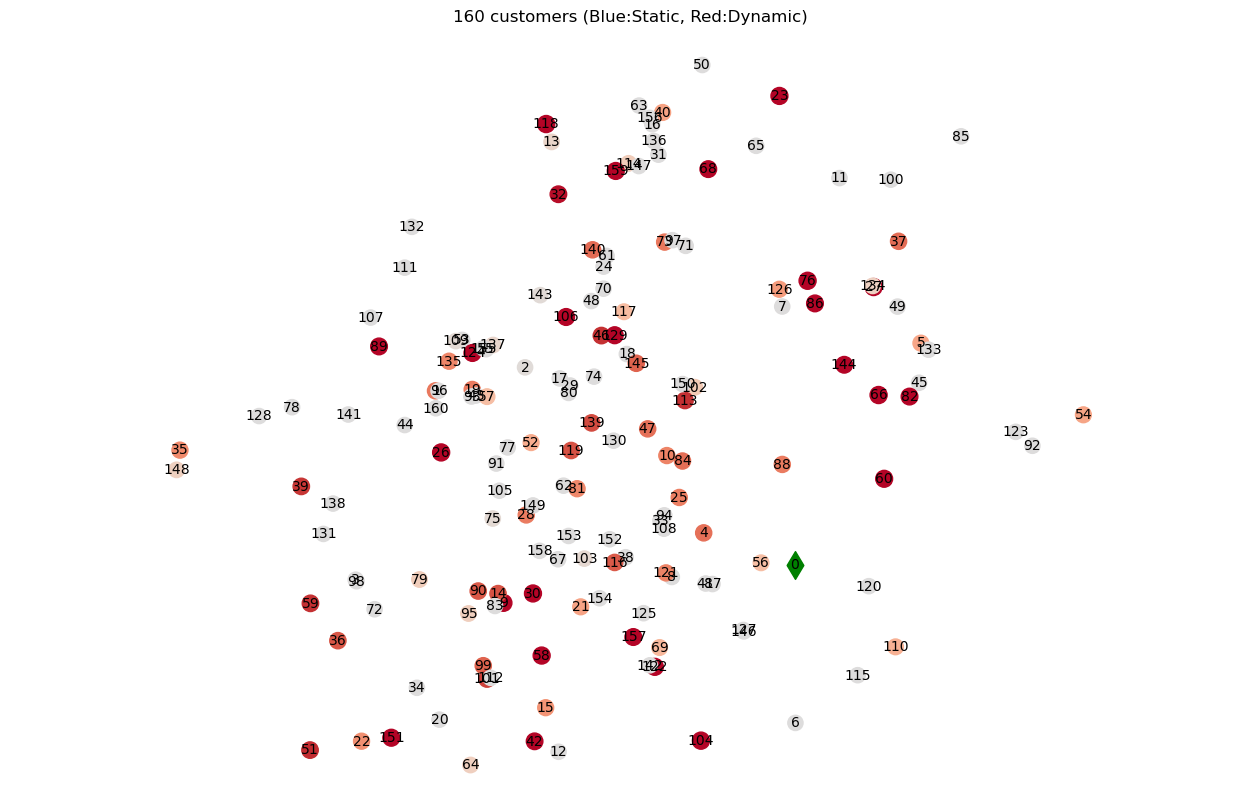

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (16,10))
plot_customers(ax1, data_t.nodes[1])

In [30]:
import torch


class DVRPSR_Environment:
    # vehicle coordinates(x_i,y_i), veh_time_time_budget, total_travel_time
    vehicle_feature = 4
    # customers feature: coordinates (x_i,y_i), service time, arrival_time
    customer_feature = 4

    def __init__(self,
                 data=None,
                 nodes=None,
                 edges_attributes=None,
                 vehicle_count=2,
                 vehicle_speed=1,
                 vehicle_time_budget=1,
                 pending_cost=0.1,
                 dynamic_reward=1):

        self.vehicle_count = vehicle_count
        self.vehicle_speed = data.vehicle_speed if data is not None else vehicle_speed
        self.vehicle_time_budget = data.vehicle_time_budget if data is not None else vehicle_time_budget
        self.nodes = data.nodes if nodes is None else nodes
        self.minibatch, self.nodes_count, _ = self.nodes.size()
        self.pending_cost = pending_cost
        self.dynamic_reward = dynamic_reward

    def _update_current_vehicles(self, dest, customer_index):

        dist = torch.pairwise_distance(self.current_vehicle[:, 0, :2], dest[:, 0, :2], keepdim=True)
        # total travel time and
        # budget left while travelling to destination nodes
        budget = dist / self.vehicle_speed + dest[:, :, 2]

        # update vehicle features based on destination nodes
        self.current_vehicle[:, :, :2] = dest[:, :, :2]
        self.current_vehicle[:, :, 2] -= budget
        self.current_vehicle[:, :, 3] += budget

        # update vehicles states
        self.vehicles = self.vehicles.scatter(1,
                                              self.current_vehicle_index[:, :, None].expand(-1, -1, self.vehicle_feature),
                                              self.current_vehicle)
        return dist

    def _done(self, customer_index):
        self.vehicle_done.scatter_(1,
                                   self.current_vehicle_index,
                                   torch.logical_or((self.current_vehicle[:, :, 2] <= 0), (customer_index == 0)))

        self.done = torch.logical_or(self.vehicle_done.all(),
                                     (self.pending_customers == 0).all())

    def _update_mask(self, customer_index):
        self.new_customer = False
        self.served.scatter_(1, customer_index, customer_index > 0)
        self.pending_customers = (self.served ^ True).float().sum(-1, keepdim=True) - 1

        # cost for a vehicle to go to customer and back to deport considering service duration
        # Calculate distances
        dist_vehicle_to_customers = torch.norm(self.current_vehicle.squeeze(1)[:, None, :2] - self.nodes[:, :, :2], dim=2)
        dist_customers_to_depot = torch.norm(self.nodes[:, :, :2] - self.nodes[:, 0, None, :2], dim=2)
        cost = (dist_vehicle_to_customers + dist_customers_to_depot) / self.vehicle_speed
        
        print(cost.size(), cost)
        cost += self.nodes[:, :, 2]
        
        overtime_mask = self.current_vehicle[:, :, None, 2] - cost.unsqueeze(1)
        overtime = torch.zeros_like(self.mask).scatter_(1,
                                                        self.current_vehicle_index[:, :, None].
                                                        expand(-1, -1, self.nodes_count),overtime_mask < 0)
        self.mask = self.mask | self.served[:, None, :] | overtime | self.vehicle_done[:, :, None]
        # masking of depot is set to False
        self.mask[:, :, 0] = 0

    # updating current vehicle to find the next available vehicle
    def _update_next_vehicle(self, veh_index=None):
        if veh_index is None:
            avail = self.vehicles[:, :, 3].clone()
            avail[self.vehicle_done] = float('inf')
            self.current_vehicle_index = avail.argmin(1, keepdim=True)
        else:
            self.current_vehicle_index = veh_index

        self.current_vehicle = self.vehicles.gather(1, self.current_vehicle_index[:, :, None].expand(-1, -1, self.vehicle_feature))
        self.current_vehicle_mask = self.mask.gather(1, self.current_vehicle_index[:, :, None].expand(-1, -1, self.nodes_count))

    def _update_dynamic_customers(self, veh_index):
        time = self.current_vehicle[:, :, 3].clone()
        reveal_dyn_reqs = torch.logical_and((self.customer_mask), (self.nodes[:, :, 3] <= time))
        if reveal_dyn_reqs.any():
            self.new_customer = True
            self.customer_mask = self.customer_mask ^ reveal_dyn_reqs
            self.mask = self.mask ^ reveal_dyn_reqs[:, None, :].expand(-1, self.vehicle_count, -1)
            self.vehicle_done = torch.logical_and(self.vehicle_done, (reveal_dyn_reqs.any(1) ^ True).unsqueeze(1))

            # avail vehicle only when time budget is left
            time_violate = (self.vehicles[:, :, 2] <= 0)
            self.vehicle_done = torch.logical_or(self.vehicle_done, time_violate)

            self.vehicles[:, :, 3] = torch.max(self.vehicles[:, :, 3], time)
            self._update_next_vehicle(veh_index)

    def reset(self):
        # reset vehicle (minibatch*veh_count*veh_feature)
        self.vehicles = self.nodes.new_zeros((self.minibatch, self.vehicle_count, self.vehicle_feature))
        self.vehicles[:, :, :2] = self.nodes[:, :1, :2]
        self.vehicles[:, :, 2] = self.vehicle_time_budget

        # reset vehicle done
        self.vehicle_done = self.nodes.new_zeros((self.minibatch, self.vehicle_count), dtype=torch.bool)
        self.done = False

        # initialize reward as tour length
        self.tour_length = torch.zeros((self.minibatch, 1)).to(self.nodes.device)

        # reset cust_mask
        self.customer_mask = self.nodes[:, :, 3] > 0

        # reset new customers and served customer since now to zero (all false)
        self.new_customer = True
        self.served = torch.zeros_like(self.customer_mask)
        self.pending_customers = (self.served ^ True).float().sum(-1, keepdim=True) - 1

        # reset mask (minibatch*veh_count*nodes)
        self.mask = self.customer_mask[:, None, :].repeat(1, self.vehicle_count, 1)

        # reset current vehicle index, current vehicle, current vehicle mask
        self.current_vehicle_index = self.nodes.new_zeros((self.minibatch, 1), dtype=torch.int64)
        self.current_vehicle = self.vehicles.gather(1,
                                                    self.current_vehicle_index[:, :, None].
                                                    expand(-1, -1, self.vehicle_feature))
        self.current_vehicle_mask = self.mask.gather(1,
                                                     self.current_vehicle_index[:, :, None].
                                                     expand(-1, -1, self.nodes_count))



    def step(self, customer_index, veh_index=None):
        dest = self.nodes.gather(1, customer_index[:, :, None].expand(-1, -1, self.customer_feature))
        dist = self._update_current_vehicles(dest, customer_index)
        self._done(customer_index)
        self._update_mask(customer_index)
        self._update_next_vehicle(veh_index)
        self._update_dynamic_customers(veh_index)

        self.tour_length += dist

        reward = +dist

        if self.done:
            # penalty for all and static pending customers
            pending_customers = torch.logical_and((self.served ^ True),
                                                  (self.nodes[:, :, 3] >= 0)).float().sum(-1, keepdim=True) - 1

            pending_static_customers = torch.logical_and((self.served ^ True),
                                                  (self.nodes[:, :, 3] == 0)).float().sum(-1, keepdim=True) - 1

            reward += self.pending_cost * pending_customers + self.pending_cost * pending_static_customers
            return reward
        else:
            return reward

    def state_dict(self, dest_dict=None):
        if dest_dict is None:
            dest_dict = {'vehicles': self.vehicles,
                         'vehicle_done': self.vehicle_done,
                         'served': self.served,
                         'mask': self.mask,
                         'current_vehicle_index': self.current_vehicle_index}
        else:
            dest_dict["vehicles"].copy_(self.vehicles)
            dest_dict["vehicle_done"].copy_(self.vehicle_done)
            dest_dict["served"].copy_(self.served)
            dest_dict["mask"].copy_(self.mask)
            dest_dict["current_vehicle_index"].copy_(self.current_vehicle_index)

        return dest_dict

    def load_state_dict(self, state_dict):
        self.vehicles.copy_(state_dict["vehicles"])
        self.vehicle_done.copy_(state_dict["vehicle_done"])
        self.served.copy_(state_dict["served"])
        self.mask.copy_(state_dict["mask"])
        self.current_vehicle_index.copy_(state_dict["current_vehicle_index"])
        self.current_vehicle = self.vehicles.gather(1,
                                                    self.current_vehicle_index[:, :, None].
                                                    expand(-1, -1, self.vehicle_feature))
        self.current_vehicle_mask = self.mask.gather(1, self.current_vehicle_index[:, :, None].
                                                     expand(-1, -1, self.customer_feature))

In [37]:
env.step(torch.tensor([[2],[2],[2],[2],[2]]))

torch.Size([5, 161]) tensor([[0.0783, 0.0928, 0.0783, 0.1011, 0.1159, 0.0967, 0.1490, 0.1142, 0.0978,
         0.1115, 0.0947, 0.0944, 0.1416, 0.1212, 0.0856, 0.1671, 0.1403, 0.0876,
         0.0819, 0.0941, 0.1130, 0.0832, 0.2095, 0.1643, 0.1493, 0.1197, 0.0930,
         0.0863, 0.0811, 0.0870, 0.1835, 0.1421, 0.1305, 0.1379, 0.1128, 0.1033,
         0.1390, 0.1020, 0.1265, 0.1507, 0.1158, 0.1472, 0.0848, 0.1094, 0.1051,
         0.1956, 0.0811, 0.1911, 0.0822, 0.0791, 0.0869, 0.0789, 0.1803, 0.1009,
         0.0864, 0.0788, 0.0784, 0.2229, 0.0889, 0.0815, 0.1298, 0.0792, 0.0943,
         0.0827, 0.1088, 0.0789, 0.1012, 0.0866, 0.1489, 0.0946, 0.0880, 0.0863,
         0.1801, 0.1487, 0.1070, 0.0815, 0.0936, 0.0905, 0.0876, 0.1341, 0.1867,
         0.0848, 0.1617, 0.0957, 0.1093, 0.1122, 0.1618, 0.1305, 0.1147, 0.0896,
         0.0807, 0.0888, 0.0947, 0.0915, 0.1433, 0.0796, 0.1441, 0.1726, 0.0811,
         0.0969, 0.1561, 0.1095, 0.1732, 0.1746, 0.0930, 0.1653, 0.0857, 0.1801,
       

tensor([[0.1684],
        [0.0474],
        [0.0713],
        [0.2303],
        [0.2186]])

In [35]:
env = DVRPSR_Environment(data_t)
env.reset()
env.step(torch.tensor([[1],[1],[1],[1],[1]]))

torch.Size([5, 161]) tensor([[0.0337, 0.0337, 0.1375, 0.1346, 0.0637, 0.0432, 0.1062, 0.0957, 0.0454,
         0.0524, 0.0359, 0.0425, 0.1311, 0.0728, 0.0921, 0.1250, 0.1316, 0.0645,
         0.0880, 0.0795, 0.1175, 0.0578, 0.1600, 0.1122, 0.1638, 0.0806, 0.0804,
         0.0703, 0.0378, 0.0341, 0.1433, 0.0842, 0.1575, 0.0845, 0.0539, 0.1624,
         0.0804, 0.0676, 0.0983, 0.1662, 0.1215, 0.0908, 0.1065, 0.0799, 0.0513,
         0.1449, 0.0342, 0.1385, 0.0697, 0.0470, 0.0995, 0.0599, 0.1303, 0.0826,
         0.0915, 0.1060, 0.0910, 0.1759, 0.0660, 0.0625, 0.0845, 0.0410, 0.0803,
         0.0337, 0.0593, 0.1258, 0.1094, 0.0916, 0.0983, 0.0568, 0.0626, 0.0462,
         0.1280, 0.1629, 0.1474, 0.0909, 0.0344, 0.1128, 0.0346, 0.1253, 0.1303,
         0.1234, 0.1137, 0.1232, 0.1656, 0.0541, 0.1285, 0.1575, 0.0650, 0.0708,
         0.0840, 0.0696, 0.0714, 0.0501, 0.1275, 0.0977, 0.0859, 0.1175, 0.0975,
         0.0400, 0.0979, 0.1111, 0.1266, 0.1374, 0.0339, 0.1345, 0.0544, 0.1456,
       

tensor([[0.0957],
        [0.2044],
        [0.0736],
        [0.1573],
        [0.0879]])

In [12]:
args = ParseArguments()
Lambda = 0.05
dod = 0.48
horizon = 480
vehicle_count = 4

data = torch.load("./data/validation/{}_{}_{}_{}/val.pth".format(Lambda, dod, vehicle_count, horizon ))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(4,6,51, encoder_layer=4, model_size = 128, ff_size_actor=128,ff_size_critic=128, edge_embedding_dim=64)
checkpoint = torch.load("./output/exp10nodes_entropy0.05_0.005_0.24_2_230813/epoch50.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

4.848484848484849


## Plot Customers and Routes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_12970/2939546372.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_12970/2939546372.py:38: Matplot

[[35, 49, 9, 17, 16, 1], [26, 33, 46, 41, 47, 7, 42, 38, 13], [48, 19, 6, 23, 27, 43, 24, 29, 3], [25, 32, 34, 40, 15, 31]]
[[4, 2, 12, 49, 23, 13, 6], [22, 17, 5, 36, 38, 3, 25, 32], [11, 24, 1, 10, 50, 47, 48], [16, 33, 31, 18, 20, 37, 45, 19, 29, 41]]
[[40, 11, 29, 15, 38, 1], [48, 49, 9, 13, 21, 41, 46, 4, 36, 34, 20], [42, 16, 37, 25, 18, 12, 3, 5, 22, 26], [31, 39, 35, 27, 43, 44, 10, 14, 23]]
[[34, 33, 20, 47, 38, 42, 44, 3, 43, 2, 22, 48], [37, 11, 23, 12, 13, 19, 4, 9, 17, 25], [49, 50, 26, 29, 28, 1, 41, 8, 30, 21], [46, 5, 31, 36, 15, 32, 10, 27, 39, 40]]


/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_12970/2939546372.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_12970/2939546372.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap


[[28, 14, 6, 36, 15, 19, 49, 4, 22, 44, 43], [50, 11, 7, 13, 25, 34, 2, 37, 46, 42, 23], [9, 31, 41, 39, 10, 26], [3, 5, 32, 35, 17, 20, 1, 27, 21]]


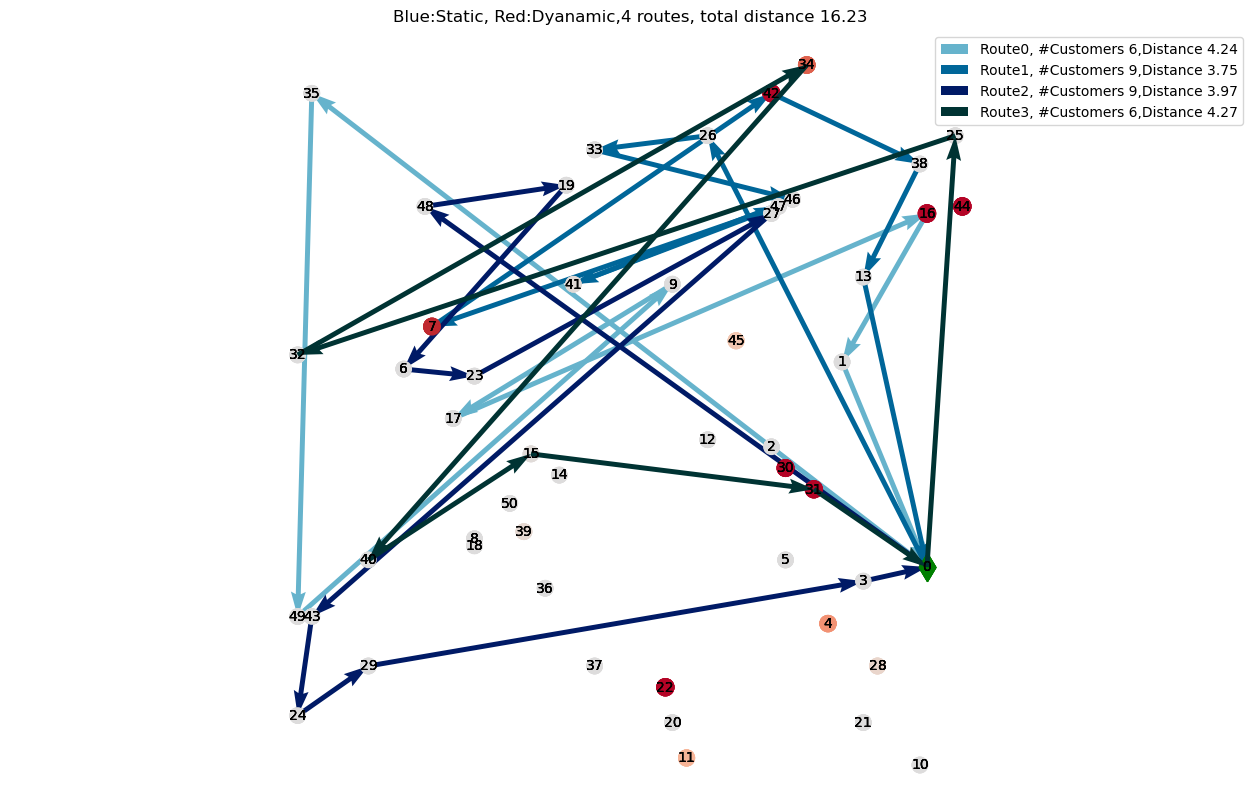

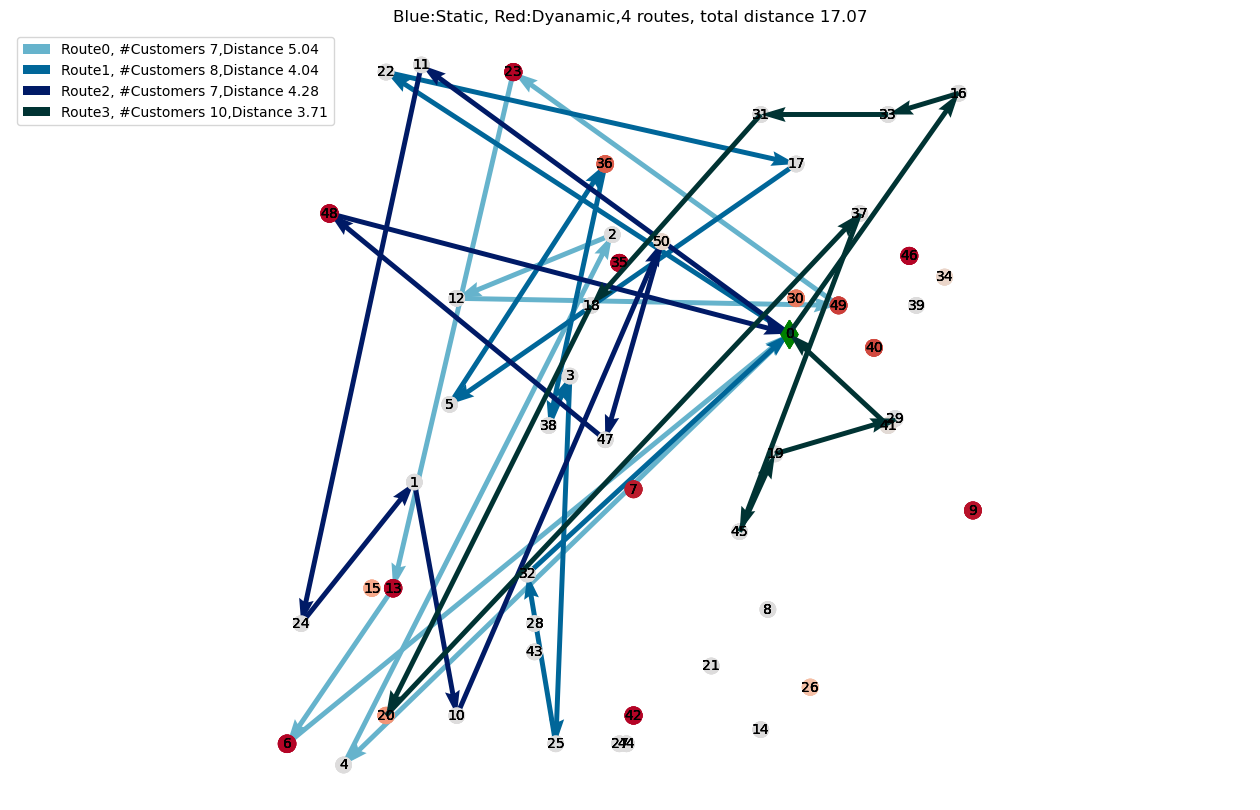

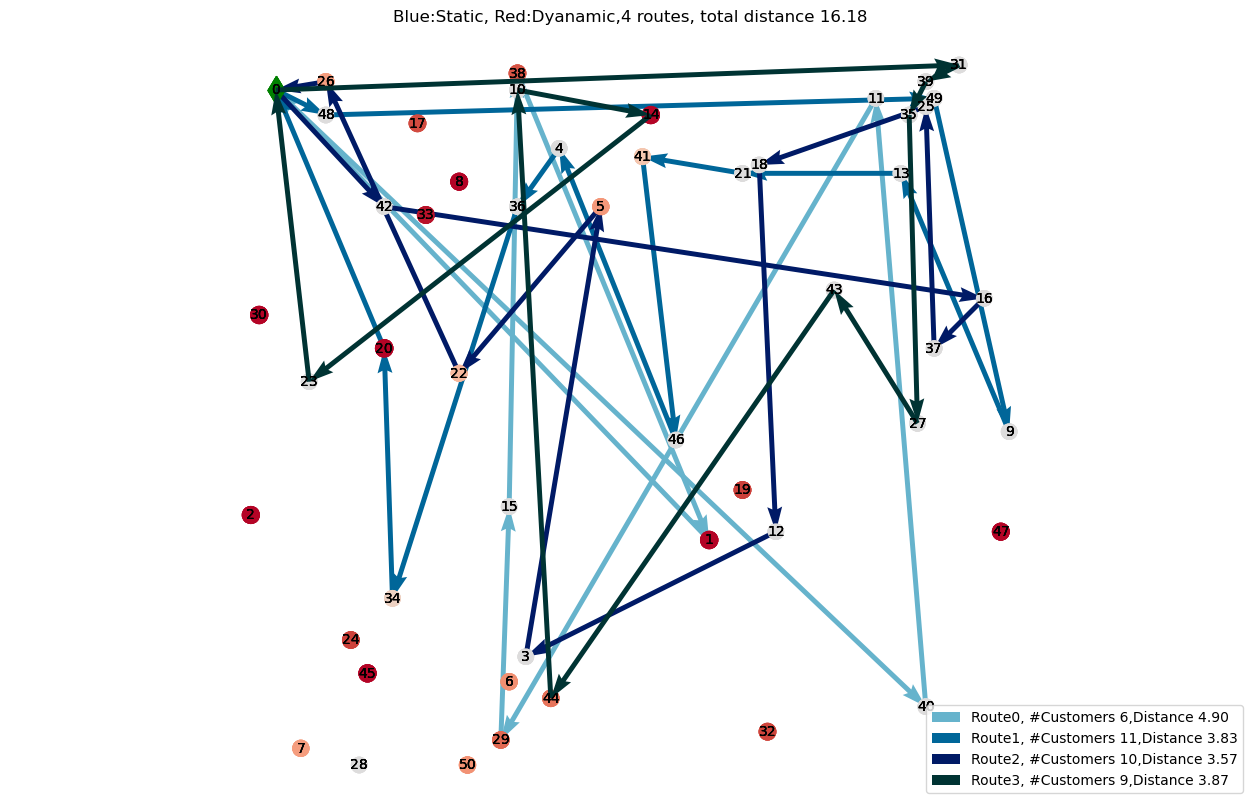

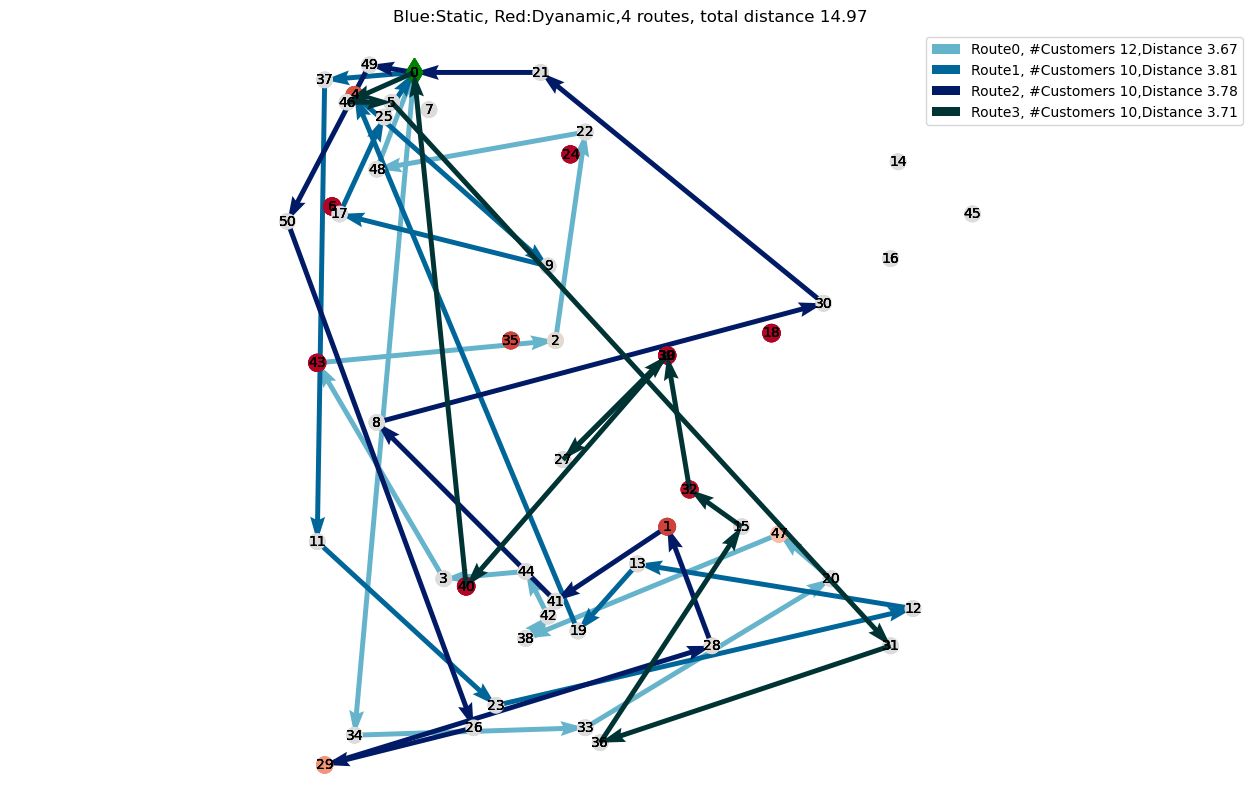

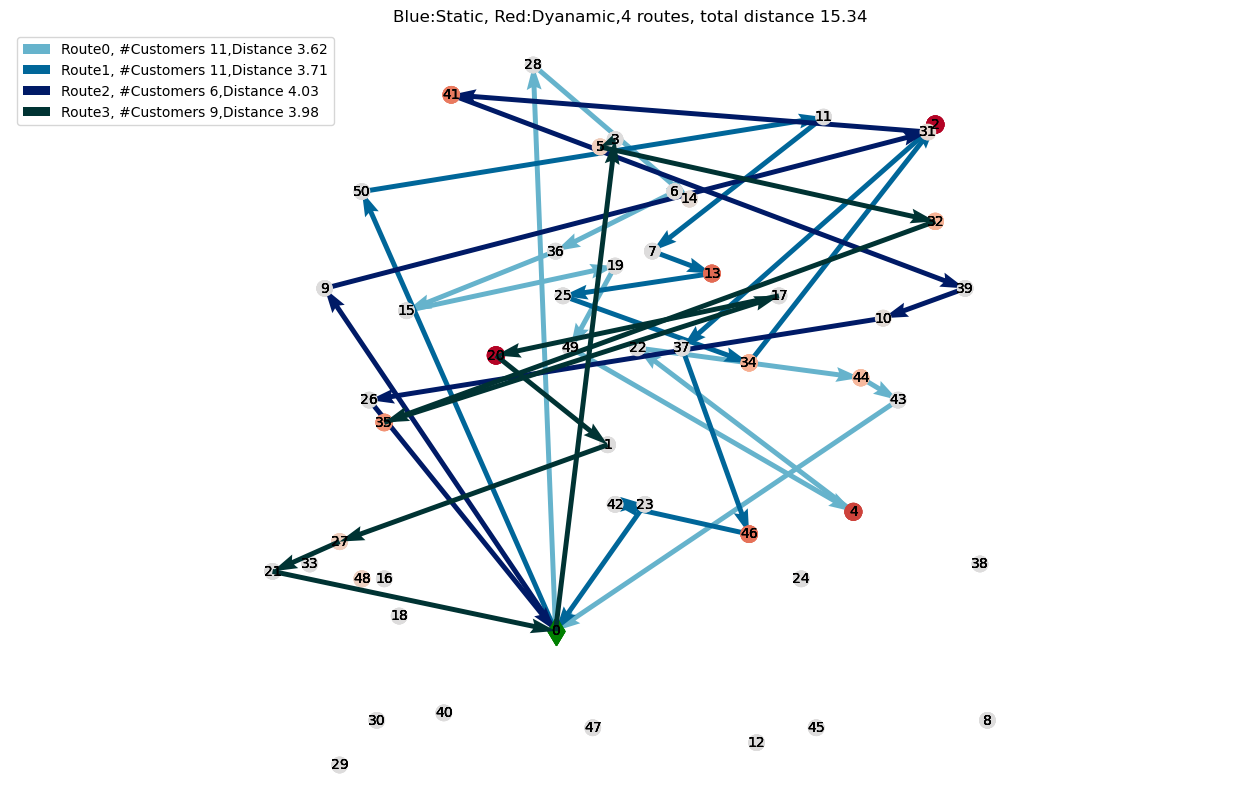

In [13]:
agent_actions = []
with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(data = data_t, pending_cost=0, dynamic_reward=0)
        actions,logps, rewards,_ = learner.act(env)
        #print(minibatch[0])
        #print(env.vehicles)
        #print(env.nodes)
        #print(actions)
        
        agent_actions.append(actions)
        
# Convert tensor to array
agent_actions_to_array = np.array([[[t[0][i].item(), t[1][i].item()] 
                                    for i in range(len(t[0]))] 
                                    for t in agent_actions[0]])
tours = []

for i in range(len(agent_actions_to_array[0])):
    temp = []
    for j in range(len(agent_actions_to_array)):
        temp.append(agent_actions_to_array[j][i])
    tours.append(temp)


for i, (data, tour) in enumerate(zip(env.nodes, tours)):
    
    tour = pd.DataFrame(tour)
    tour.columns = ['vehicles','customers']  
    
    # Create a grouping column
    tour['group'] = tour.groupby('vehicles').cumcount()

    # Reshape the DataFrame
    tour = tour.pivot(index='group', columns='vehicles', values='customers')

    # Rename the columns
    column_names = [f'vehicles_{val}' for val in tour.columns]
    tour.columns = column_names
    tour = tour.fillna(0).astype(int)

    routes = []
    for vehicle_name in list(tour.columns):
        routes.append(list(tour[vehicle_name]))

    routes_without_depot = []
    for route in routes:
        r = [cust for cust in route if cust!=0]
        routes_without_depot.append(r)
        
    print(routes_without_depot)
    if ((len(routes_without_depot[0]) > 0 ) and (len(routes_without_depot[0]) > 0)):
        plot_vehicle_routes(data, routes_without_depot)
    

## Quality of Service (QOS)

In [14]:
data = torch.load("./data/validation/{}_{}_{}_{}/val_accuracy.pth".format(Lambda, dod, vehicle_count, horizon ))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(4,6,41, encoder_layer=4, model_size = 128, ff_size_actor=128,ff_size_critic=128, edge_embedding_dim=64)
checkpoint = torch.load("./output/exp10nodes_entropy0.05_0.005_0.24_2_230813/epoch50.pth", 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

costs = []
acceptance_rate = []


with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(data = data_t, pending_cost=0, dynamic_reward=0)
        actions,_, rewards,_ = learner.act(env)
        costs.append(torch.stack(rewards).sum(dim=0).squeeze(-1))   
        total_dynamic_requests = (env.nodes[:,:,3]>=0).sum(1).float()
        total_dynamic_requests_pending = (torch.logical_and(env.served^True, (env.nodes[:,:,3]>0))).sum(1).float()
        acceptance_rate.append(1 - total_dynamic_requests_pending/total_dynamic_requests)     
    costs = torch.cat(costs, 0)
    acceptance_rate = torch.cat(acceptance_rate, 0)
    
acceptance_rate = [0 if math.isnan(x) else x for x in acceptance_rate]
    

print("Costs mean:{:.2f} +- std:{:.2f} and Acceptance rate {:.4f}".format(costs.mean(), 
                                                                          costs.std(),
                                                                          np.mean(acceptance_rate)))     

4.848484848484849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:02<00:00,  9.69s/it]

Costs mean:15.80 +- std:0.59 and Acceptance rate 0.8454
